In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
import matplotlib.pyplot as plt
import numpy as np
import os

2025-07-16 11:50:09.674523: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 11:50:09.683850: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 11:50:09.687414: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 11:50:09.696353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752666609.712705  101395 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752666609.71

In [2]:
DATA_DIR = '/workspaces/Recycle-It-Gradio-App/data'
IMAGE_SIZE = (224, 224) # Çoğu önceden eğitilmiş model bu boyutu kullanır.
BATCH_SIZE = 32 # Model, her adımda 32 resimlik gruplar halinde öğrenecek.
VALIDATION_SPLIT = 0.2 # Verinin %20'sini doğrulama için ayıracağız.

In [3]:
print("Eğitim veri seti oluşturuluyor...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=1337, # Tekrarlanabilir sonuçlar için bir seed belirleyelim.
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int' # Etiketler '0, 1, 2...' şeklinde tam sayı olacak.
)

print("\nDoğrulama veri seti oluşturuluyor...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Eğitim veri seti oluşturuluyor...
Found 2527 files belonging to 6 classes.
Using 2022 files for training.


2025-07-16 11:50:13.301183: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Doğrulama veri seti oluşturuluyor...
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation"
)
print("Veri çoğaltma katmanı hazır.")

Veri çoğaltma katmanı hazır.


In [5]:
class_names = train_ds.class_names
print("Sınıflar bu notebook için tekrar tanımlandı:", class_names)
print("Toplam sınıf sayısı:", len(class_names))

Sınıflar bu notebook için tekrar tanımlandı: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Toplam sınıf sayısı: 6


In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')

In [7]:
base_model.trainable = False
print("Temel model (MobileNetV2) yüklendi ve ağırlıkları donduruldu.")

Temel model (MobileNetV2) yüklendi ve ağırlıkları donduruldu.


In [8]:
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)

x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False) # training=False, dropout gibi katmanların bu aşamada kapalı kalmasını sağlar.

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.2)(x)

outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = keras.Model(inputs, outputs)

print("Nihai model mimarisi oluşturuldu.")

Nihai model mimarisi oluşturuldu.


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Model derlendi ve eğitime hazır.")
model.summary()

Model derlendi ve eğitime hazır.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
epochs = 20

print("Model eğitimi başlıyor...")
print(f"Toplam {epochs} epoch sürecek. Bu işlem biraz zaman alabilir.")

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

print("\nModel eğitimi tamamlandı!")

Model eğitimi başlıyor...
Toplam 20 epoch sürecek. Bu işlem biraz zaman alabilir.
Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 61s 890ms/step - accuracy: 0.4264 - loss: 1.5098 - val_accuracy: 0.7188 - val_loss: 0.7228
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 836ms/step - accuracy: 0.7379 - loss: 0.7225 - val_accuracy: 0.7644 - val_loss: 0.6304
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 840ms/step - accuracy: 0.7879 - loss: 0.5930 - val_accuracy: 0.7901 - val_loss: 0.5689
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 832ms/step - accuracy: 0.8265 - loss: 0.5066 - val_accuracy: 0.7941 - val_loss: 0.5786
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 822ms/step - accuracy: 0.8247 - loss: 0.4766 - val_accuracy: 0.8059 - val_loss: 0.5460
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 774ms/step - accuracy: 0.8393 - loss: 0.4498 - val_accuracy: 0.8079 - val_loss: 0.5479
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 784ms/step - accuracy: 0.8520 - loss: 0.4254 - val_accuracy: 0.8139 - val_loss: 0.5336
Epoch 8/20
64/6

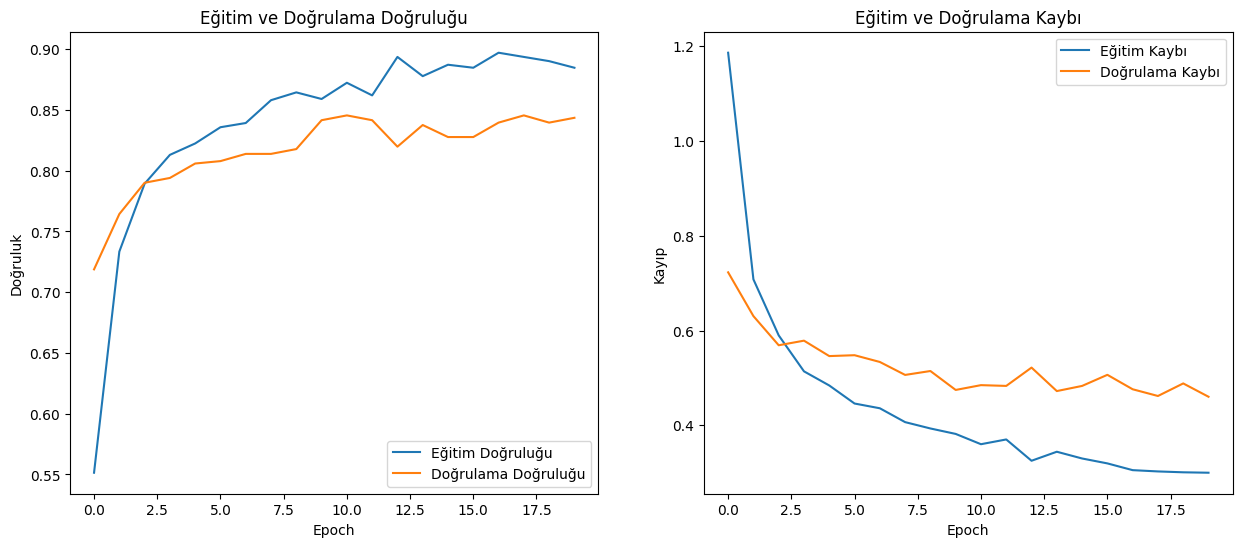

: 

In [ ]:
# Eğitim süresince toplanan metrikleri alalım.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Grafik için bir alan oluşturalım.
plt.figure(figsize=(15, 6))

# Doğruluk (Accuracy) Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')

# Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')

plt.show()

print("\nİnce ayar aşaması başlıyor...")

# Temel modelin katmanlarını eğitilebilir yapalım.
base_model.trainable = True

# Modeli, çok daha düşük bir öğrenme oranı (learning rate) ile tekrar derleyelim.
# Bu, önceden öğrenilmiş ağırlıkların bozulmasını engeller.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Çok düşük öğrenme oranı
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# İnce ayar için birkaç epoch daha eğitelim.
fine_tune_epochs = 1
total_epochs = epochs + fine_tune_epochs

# Eğitime kaldığı yerden devam edelim.
history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Önceki eğitimin bittiği yerden başla
    validation_data=val_ds
)

print("\nİnce ayar tamamlandı!")

In [ ]:
#model_filename = 'recycle_model.h5'
#model.save(model_filename)

#print(f"\nModel başarıyla '{model_filename}' adıyla kaydedildi.")
#print("Bu dosya, web uygulamamızın beyni olacak.")

In [1]:
model_foldername = 'recycle_model_tf'
model.save(model_foldername)

print(f"\nModel başarıyla '{model_foldername}' adında bir klasör olarak kaydedildi.")
print("Bu klasör, web uygulamamızın beyni olacak.")

NameError: name 'model' is not defined